In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
ds = create_linear_ds()
ds

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 10, time: 252)
Coordinates:
  * lat      (lat) float64 -55.15 -40.69 -26.22 -11.76 ... 46.1 60.56 75.02
  * lon      (lon) float64 -180.0 -140.0 -100.0 -60.0 ... 60.0 100.0 140.0 180.0
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
Data variables:
    feature  (lat, lon, time) float64 79.0 58.0 85.0 23.0 ... 3.0 60.0 18.0 nan
    target   (lat, lon, time) float64 140.0 276.5 203.0 ... 10.5 210.0 63.0

# Load in Config File

In [10]:
cfg = Config(base_dir / "configs/test_config.yml")
cfg.n_epochs

2

# Create Trainer

In [16]:
trainer = Trainer(cfg, ds)

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 676.15it/s]


In [17]:
len(trainer.train_dl)
trainer.train_dl.batch_size

30

In [18]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/514 [00:00<?, ?it/s]

Train Loss: 0.03
Valid Loss: 0.01


Training Epoch 3:   0%|          | 0/514 [00:00<?, ?it/s]

Train Loss: 0.01
Valid Loss: 0.01


Training Epoch 4:   0%|          | 0/514 [00:00<?, ?it/s]

Train Loss: 0.01
Valid Loss: 0.02


Training Epoch 5:   0%|          | 0/514 [00:00<?, ?it/s]

Train Loss: 0.01
Valid Loss: 0.01


Validation Epoch 5: 100%|██████████| 114/114 [00:04<00:00, 24.30it/s]

Train Loss: 0.01
Valid Loss: 0.01


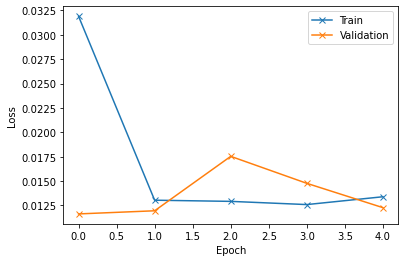

In [19]:
train_losses, valid_losses = losses
f, ax = plt.subplots()
ax.plot(train_losses, label="Train", color="C0", marker="x")
ax.plot(valid_losses, label="Validation", color="C1", marker="x")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

# Load the trained data

In [25]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 503.94it/s]


In [26]:
tester.run_test()

Test set Forward Pass: 100%|██████████| 194/194 [00:04<00:00, 39.54it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 30 and the array at index 193 has size 10

In [ ]:
%debug

> <__array_function__ internals>(5)concatenate()



ipdb>  ll


*** could not get source code


ipdb>  u


> /Users/tommylees/github/spatio_temporal/spatio_temporal/training/tester.py(131)run_test()
    129         for key in out.keys():
    130             # concatenate over batch dimension (dimension = 0)
--> 131             var_ = np.concatenate(out[key])
    132             var_ = var_.squeeze() if var_.ndim == 3 else var_
    133             var_ = _reshape(var_)



ipdb>  np.concatenate(out[key])


*** ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 30 and the array at index 193 has size 10


ipdb>  key


'time'


ipdb>  out["time"].shape


*** AttributeError: 'list' object has no attribute 'shape'


ipdb>  len(out["time"]


*** SyntaxError: unexpected EOF while parsing


ipdb>  len(out["time"])


194


ipdb>  [k.shape for k in out[key]]


[(1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), (1, 30), 

ipdb>  self.cfg.batch_size


30


ipdb>  times[0].shape[0] == self.cfg.batch_size


False


ipdb>  (times if times[0].shape[0] == self.cfg.batch_size else times.T).shape


(10, 1)


ipdb>  [k.shape for k in out[y]]


[]


ipdb>  [k.shape for k in out["y"]]


[]


ipdb>  out.keys()


dict_keys(['sim', 'obs', 'time', 'pixel', tensor([[[-0.1283]],

        [[-0.5160]],

        [[-1.4322]],

        [[ 1.4223]],

        [[-0.3750]],

        [[-1.6789]],

        [[ 1.3870]],

        [[ 0.6822]],

        [[-1.7846]],

        [[ 0.2241]]]), 'y'])


ipdb>  [k.shape for k in out["obs"]]


[(30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30

ipdb>  [k.shape for k in out["sim"]]


[(30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30, 1, 1), (30

ipdb>  [k.shape for k in out["pixel"]]


[(30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,), (30,)